In [1]:
import numpy as np
import sys
sys.path.append("../../../")
from SWIDP.process_1d_shallow import augment_workflow
from SWIDP.dispersion import generate_mixed_samples,calculate_dispersion,transform_vp_to_vs,transform_vs_to_vel_model
from p_tqdm import p_map

In [2]:
# step1: get 1d velocity model (vp model or vs)
depth_vp = np.loadtxt("./vp_demo.txt")
depth = depth_vp[:,0]
vp = depth_vp[:,1]

# step2: generate velocity model (depth, vp, vs, rho)
vs = transform_vp_to_vs(vp)

# step3: vs model augmentation
augment_nums = 100
vs_perturbation = 0.05 # relative ratio
thickness_perturbation = 0.1 # relative ratio
vel_threshold = 0.05 # km/s
thickness_threshold = 0.01 # km
min_layers_num = 3 
smooth_vel = False
smoothnodes = 10
vs_augmented = augment_workflow(vs,depth,
                              perturb_num = augment_nums,
                              vs_perturbation=vs_perturbation,
                              thickness_perturbation=thickness_perturbation,
                              vel_threshold=vel_threshold,
                              thickness_threshold=thickness_threshold,
                              min_layers_num=min_layers_num,
                              smooth_vel=smooth_vel,
                              smooth_nodes=smoothnodes)

# step4: generate velocity model (depth, vp, vs, rho)
vel_model_augmented = p_map(transform_vs_to_vel_model,list(vs_augmented),[depth]*len(vs_augmented))

# step5: generate dispersion curves [t,phase velocity, group velocity]
t = generate_mixed_samples(num_samples=100,start=0.2,end=10,uniform_num=50,log_num=20,random_num=30)
disp = p_map(calculate_dispersion,vel_model_augmented,[t]*len(vel_model_augmented))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

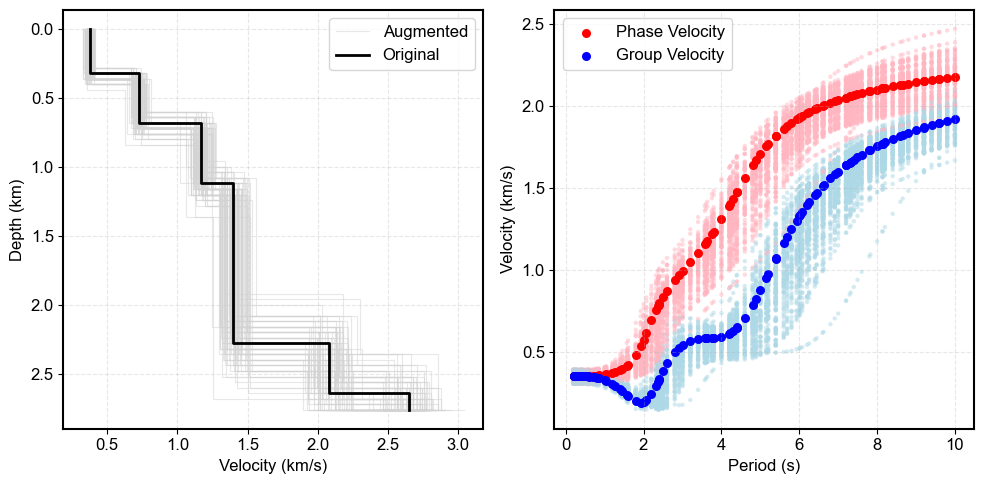

In [3]:
import matplotlib.pyplot as plt

# Set figure style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.linewidth': 1.5,
    'axes.grid': True,
    'grid.linestyle': '--',
    'grid.alpha': 0.3
})

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Left subplot - Velocity profiles
for i in range(len(vel_model_augmented)):
    ax1.step(vel_model_augmented[i][:,2], depth, color='#D3D3D3', alpha=0.5, linewidth=0.8, label="Augmented" if i==0 else "")
ax1.step(vel_model_augmented[0][:,2], depth, color='black', linewidth=2, label='Original')
ax1.invert_yaxis()
ax1.set_xlabel('Velocity (km/s)')
ax1.set_ylabel('Depth (km)')
ax1.legend(frameon=True, fancybox=True)

# Right subplot - Dispersion curves  
for i in range(len(disp)):
    ax2.scatter(disp[i][:,0], disp[i][:,1], s=10, color='#FFB6C1', alpha=0.5, edgecolor='none')
    ax2.scatter(disp[i][:,0], disp[i][:,2], s=10, color='#ADD8E6', alpha=0.5, edgecolor='none')
ax2.scatter(disp[0][:,0], disp[0][:,1], s=30, color='red', label='Phase Velocity')
ax2.scatter(disp[0][:,0], disp[0][:,2], s=30, color='blue', label='Group Velocity')
ax2.set_xlabel('Period (s)')
ax2.set_ylabel('Velocity (km/s)')
ax2.legend(frameon=True, fancybox=True)

plt.tight_layout()
plt.savefig("../../../../Figures/OpenSWI-shallow-example.png",bbox_inches="tight",dpi=300)
plt.show()